In [ ]:
!pip install --quiet lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Import statements
import numpy as np
import pandas as pd
import cv2

import os
import urllib.request
import sys
import glob
import json

import sklearn
from sklearn.model_selection import train_test_split

import random
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [ ]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision import models
import torch.optim.lr_scheduler as lr_scheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [ ]:
df = pd.read_csv("metadata.csv")

df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [ ]:
df.shape

(95634, 5)

In [ ]:
len(df[df["label"] == "FAKE"]), len(df[df["label"] == "REAL"])

(79341, 16293)

In [ ]:
real_df = df[df["label"] == "FAKE"]
fake_df = df[df["label"] == "REAL"]
SAMPLE_SIZE = 8000

real_df = real_df.sample(SAMPLE_SIZE, random_state=42)
fake_df = fake_df.sample(SAMPLE_SIZE, random_state=42)

sample_df = pd.concat([real_df, fake_df])

In [ ]:
train_data, test_data = train_test_split(
    sample_df,
    test_size=0.2,
    random_state=42,
    stratify=sample_df["label"]
)

test_data, val_data = train_test_split(
    test_data,
    test_size=0.5,
    random_state=42,
    stratify=test_data["label"]
)

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((12800, 5), (1600, 5), (1600, 5))

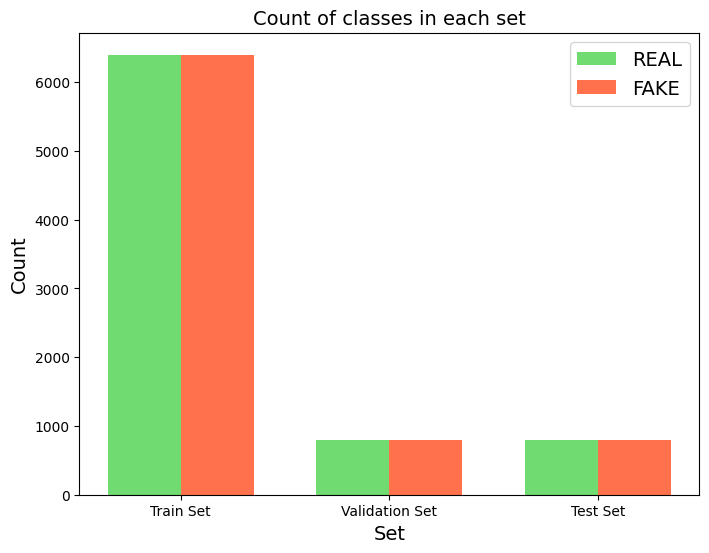

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_data, val_data, and test_data are pandas DataFrames
y = dict()

y[0] = []
y[1] = []

# Iterating through each label set
for set_name in (np.array(train_data['label']), np.array(val_data['label']), np.array(test_data['label'])):
    y[0].append(np.sum(set_name == 'REAL'))  # Count the 'REAL' labels
    y[1].append(np.sum(set_name == 'FAKE'))  # Count the 'FAKE' labels

# Define the bar positions and width
labels = ['Train Set', 'Validation Set', 'Test Set']
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bars for 'REAL' and 'FAKE' categories
rects1 = ax.bar(x - width/2, y[0], width, label='REAL', color='#33cc33', alpha=0.7)
rects2 = ax.bar(x + width/2, y[1], width, label='FAKE', color='#ff3300', alpha=0.7)

# Add labels, title, and custom ticks on the x-axis
ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_title('Count of classes in each set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving faces_224.zip to faces_224.zip


In [ ]:
import zipfile
import os

# Specify the path to the zip file
zip_path = "faces_224.zip"

# Define the extraction directory
extract_dir = "./faces_224"

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to ./faces_224


In [ ]:
print('./faces_224/' + train_data.loc[i, 'videoname'][:-4] + '.jpg')

./faces_224/figfxyhild.jpg


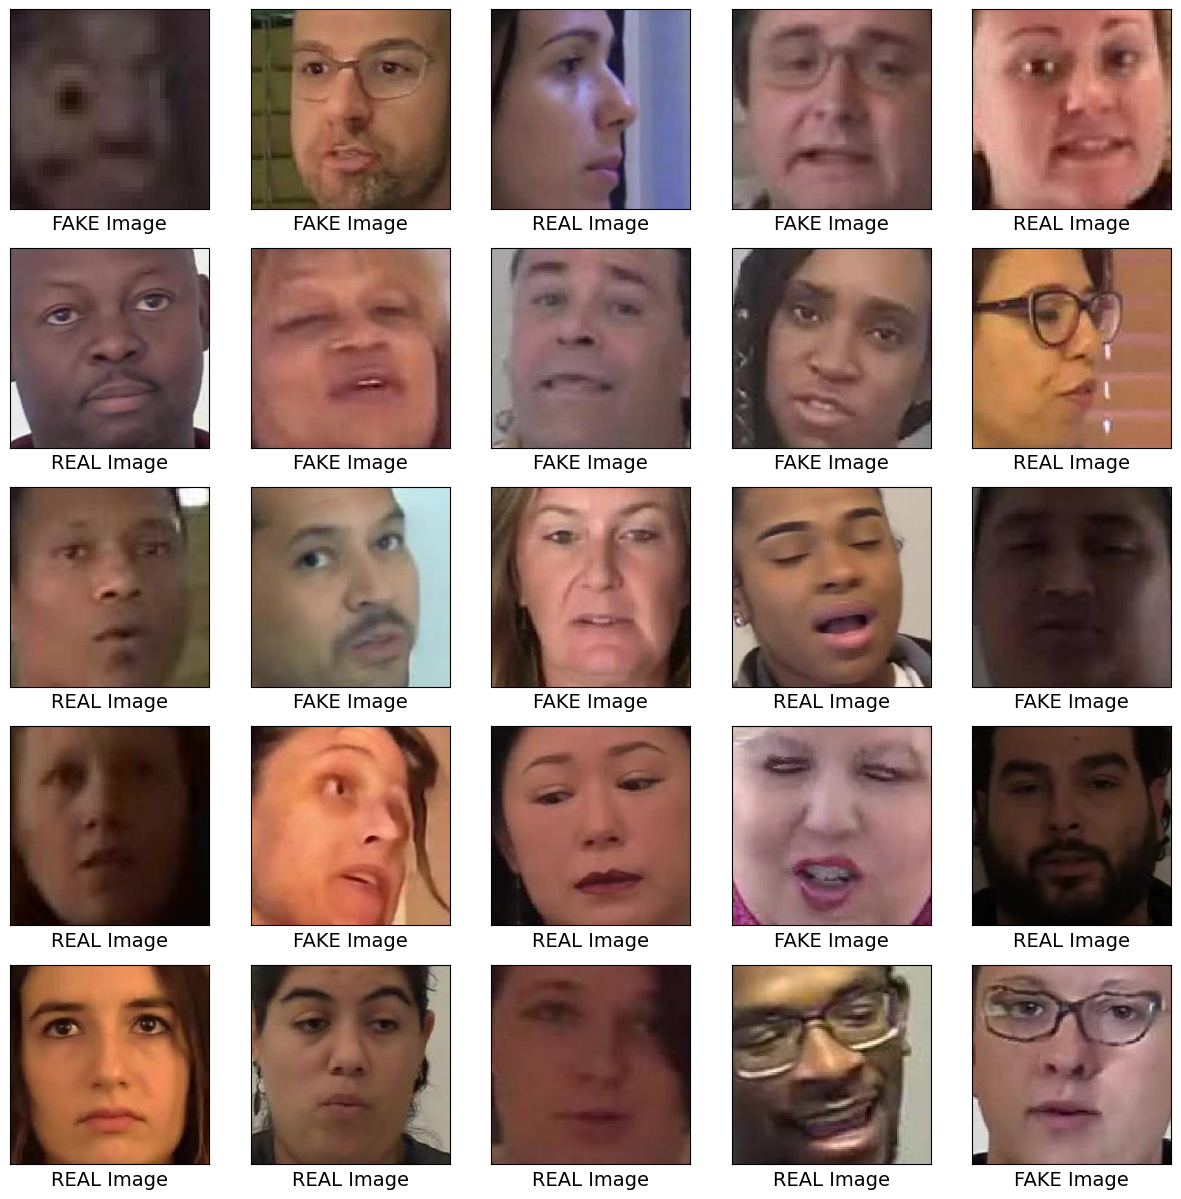

In [ ]:
plt.figure(figsize=(15, 15))
for cur, i in enumerate(train_data.index[25:50]):
    plt.subplot(5, 5, cur + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Construct the image path
    image_path = './faces_224/faces_224/' + train_data.loc[i, 'videoname'][:-4] + '.jpg'


    image_bgr = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the image
    plt.imshow(image_rgb)

    # Add the label
    if train_data.loc[i, 'label'] == 'FAKE':
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()

In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, data_name, is_training=True):
        """
        Args:
            data_name (pd.DataFrame): DataFrame containing 'videoname' and 'label' columns.
        """
        self.data_name = data_name
        self.is_training = is_training

        # Initialize the images and labels using the retrieve_data function logic
        self.images, self.labels = self.retrieve_data()

        # Training augmentations
        if is_training:
            self.transform_func = A.Compose([
                A.Resize(224, 224),
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.OneOf([
                    A.GaussNoise(p=1),
                    A.GaussianBlur(p=1),
                ], p=0.2),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2()
            ])
        else:
            # Validation/test transforms
            self.transform_func = A.Compose([
                A.Resize(224, 224),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2()
            ])

    def retrieve_data(self):
        images, labels = [], []

        for img, label in zip(self.data_name["videoname"], self.data_name["label"]):
            image = cv2.imread("./faces_224/faces_224/" + img[:-4] + ".jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB format
            images.append(image)

            # Convert labels: FAKE -> 1, REAL -> 0
            if label == "FAKE":
                labels.append(1)
            else:
                labels.append(0)

        return np.array(images), np.array(labels)

    def __len__(self):
        """Returns the size of the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Fetch a single sample from the dataset"""
        # Get image and label
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transforms - note the dictionary format required by Albumentations
        transformed = self.transform_func(image=image)
        image = transformed["image"]  # Get the transformed image from the result dictionary

        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
train_data = DeepfakeDataset(data_name=train_data)
val_data = DeepfakeDataset(data_name=val_data)
test_data = DeepfakeDataset(data_name=test_data)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

# Verify if dataset is created accurately
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [ ]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Train loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Progress bar for training batches
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch')

        for imgs, labels in train_bar:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
            train_losses.append(train_loss)

            # Update progress bar with the current loss
            train_bar.set_postfix(loss=loss.item())

        # Validate
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{num_epochs}', unit='batch')

            for imgs, labels in val_bar:
                imgs = imgs.to(device)
                labels = labels.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)

                _, preds = torch.max(outputs, dim=1)
                correct_preds += torch.sum(preds == labels)

                # Update validation progress bar with the current loss
                val_bar.set_postfix(loss=loss.item())

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        accuracy = correct_preds.double() / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader.dataset):.4f}, '
              f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

In [ ]:
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct_preds = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            test_loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, dim=1)
            correct_preds += torch.sum(preds == labels)

            test_losses.append(test_loss.item())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = float((correct_preds.double() / len(test_loader.dataset)) * 100)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print("\nAccuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)

# Build Resnet model

change resenet 50 to resnet 152?

In [ ]:
# 50
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50Classifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResNet50Classifier, self).__init__()

        # Load pretrained ResNet50
        self.model = models.resnet50(pretrained=True)

        # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Replace with Identity to get features

        # Create new classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),  # num_features is 2048 for ResNet50
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)  # 2 classes: real and fake
        )

    def forward(self, x):
        if len(x.shape) == 5:
            # Input shape: [batch, channels, sequence_length, height, width]
            batch_size, channels, seq_len, height, width = x.shape

            # Rearrange to [batch * sequence_length, channels, height, width]
            x = x.view(batch_size * seq_len, channels, height, width)

            # Extract features using ResNet for each frame
            features = self.model(x)  # Output shape: [batch * sequence_length, 2048]

            # Reshape to [batch_size, seq_len, 2048] for averaging over the sequence dimension
            features = features.view(batch_size, seq_len, -1)

            # Average pool over frames in the sequence
            features = features.mean(dim=1)  # Shape: [batch_size, 2048]
        else:
            # Single image input (4D tensor), directly extract features
            features = self.model(x)  # Shape: [batch_size, 2048]

        # Apply classifier
        x = self.classifier(features)

        return x

    def get_features(self, x):
        """Extract features before classification layer"""
        if len(x.shape) == 5:  # Video input
            batch_size, channels, seq_len, height, width = x.shape
            x = x.view(batch_size * seq_len, channels, height, width)
            features = self.model(x)
            features = features.view(batch_size, seq_len, -1).mean(dim=1)
        else:  # Single image input
            features = self.model(x)
        return features

    def freeze_backbone(self, freeze=True):
        """Freeze or unfreeze the feature extractor"""
        for param in self.model.parameters():
            param.requires_grad = not freeze

    def unfreeze_last_layers(self, num_layers=2):
        """Unfreeze the last few layers of the backbone"""
        # First freeze everything
        self.freeze_backbone(True)

        # Then unfreeze the last layers
        for layer in list(self.model.children())[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

In [ ]:
# 152
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet152Classifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResNet152Classifier, self).__init__()

        # Load pretrained ResNet152
        self.model = models.resnet152(pretrained=True)

        # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Replace with Identity to get features

        # Create new classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),  # num_features is 2048 for ResNet152
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)  # 2 classes: real and fake
        )

    def forward(self, x):
        if len(x.shape) == 5:
            # Input shape: [batch, channels, sequence_length, height, width]
            batch_size, channels, seq_len, height, width = x.shape

            # Rearrange to [batch * sequence_length, channels, height, width]
            x = x.view(batch_size * seq_len, channels, height, width)

            # Extract features using ResNet for each frame
            features = self.model(x)  # Output shape: [batch * sequence_length, 2048]

            # Reshape to [batch_size, seq_len, 2048] for averaging over the sequence dimension
            features = features.view(batch_size, seq_len, -1)

            # Average pool over frames in the sequence
            features = features.mean(dim=1)  # Shape: [batch_size, 2048]
        else:
            # Single image input (4D tensor), directly extract features
            features = self.model(x)  # Shape: [batch_size, 2048]

        # Apply classifier
        x = self.classifier(features)

        return x

    def get_features(self, x):
        """Extract features before classification layer"""
        if len(x.shape) == 5:  # Video input
            batch_size, channels, seq_len, height, width = x.shape
            x = x.view(batch_size * seq_len, channels, height, width)
            features = self.model(x)
            features = features.view(batch_size, seq_len, -1).mean(dim=1)
        else:  # Single image input
            features = self.model(x)
        return features

    def freeze_backbone(self, freeze=True):
        """Freeze or unfreeze the feature extractor"""
        for param in self.model.parameters():
            param.requires_grad = not freeze

    def unfreeze_last_layers(self, num_layers=2):
        """Unfreeze the last few layers of the backbone"""
        # First freeze everything
        self.freeze_backbone(True)

        # Then unfreeze the last layers
        for layer in list(self.model.children())[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

In [ ]:
model = ResNet50Classifier()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, factor=0.5, patience=1, verbose=True)
num_epochs = 5

train_model(model, train_loader,val_loader, criterion, optimizer, scheduler, num_epochs)
print("\n")
evaluate_model(model, test_loader, criterion)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Training Epoch 1/5:   0%|          | 0/800 [00:00<?, ?batch/s]

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Training and Validation Loss
plt.plot(num_epochs, train_losses, label="Training Loss")
plt.plot(num_epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Deepfake Video Classification

need ajustment on folder/datasets, 2 needed

In [ ]:
DATA_FOLDER = "/kaggle/input/deepfake-detection-challenge"
TRAIN_SAMPLE_FOLDER = "train_sample_videos"
TEST_FOLDER = "test_videos"

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

In [ ]:
train_sample_metadata = pd.read_json(
    "/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json"
).T

train_sample_metadata.head()

In [ ]:
train_sample_metadata \
.groupby("label")["label"] \
.count() \
.plot(figsize=(8, 6), kind="bar", title="Labels distribution in dataset")

In [ ]:
fake_train_sample_videos = list(train_sample_metadata.loc[train_sample_metadata["label"] == "FAKE"].sample(3).index)

fake_train_sample_videos

In [ ]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

In [ ]:
for video_file in fake_train_sample_videos:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [ ]:
real_train_sample_videos = list(train_sample_metadata.loc[train_sample_metadata["label"] == "REAL"].sample(3).index)

real_train_sample_videos

In [ ]:
for video_file in real_train_sample_videos:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [ ]:
train_sample_metadata["original"].value_counts()[0:5]

In [ ]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv2.VideoCapture(video_path)
        ret, frame = capture_image.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')

In [ ]:
same_original_fake_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.original=='atvmxvwyns.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

In [ ]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])

test_videos.head()

In [ ]:
display_image_from_video(os.path.join(DATA_FOLDER, TEST_FOLDER, test_videos.iloc[1].video))

In [ ]:
fake_videos = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].index)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_FOLDER, subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

play_video(fake_videos[10])

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
     cap = cv2.VideoCapture(path)
     frames = []
     try:
         while True:
             ret, frame = cap.read()
             if not ret:
                 break
             frame = crop_center_square(frame)
             frame = cv2.resize(frame, resize)
             frame = frame[:, :, [2, 1, 0]]
             frames.append(frame)

             if len(frames) == max_frames:
                 break
     finally:
         cap.release()
     return np.array(frames)

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(np.int)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
metafiles = sorted(glob.glob('/kaggle/input/dfdc-video-faces/part*/*/*.json'))
train_metafiles = metafiles[2:]
eval_metafiles = metafiles[:2]
print(train_metafiles)
print(eval_metafiles)

In [ ]:
class VideoDataset(Dataset):

    def __init__(self, dataset_type, meta_files, batch_size):
        self.dataset_type = dataset_type
        self.batch_size = batch_size
        self.clip_shape = (16, 112, 112)
        self.load_meta(meta_files)

        print('%s dataset: %d real and %d fake samples' % (
              dataset_type, self.n_reals, self.n_fakes))

    def load_clip(self, filename, target):
        depth, height, width = self.clip_shape
        clip = np.zeros((3, depth, height, width), dtype=np.uint8)
        reader = cv2.VideoCapture(filename)
        if not reader.isOpened():
            logging.warn('could not open %s' % filename)
            return torch.from_numpy(clip).float()

        # If training, use the same cropping parameters for an entire set
        # of video clips
        if target == 0 or self.dataset_type == 'eval':
            nframes = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_height = int(reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_width = int(reader.get(cv2.CAP_PROP_FRAME_WIDTH))
            self.start_frame = random.randint(0, nframes - self.clip_shape[0])
            self.start_row = random.randint(0, frame_height - height)
            self.start_col = random.randint(0, frame_width - width)

        for i in range(self.start_frame):
            reader.grab()

        for i in range(depth):
            reader.grab()
            success, frame = reader.retrieve()
            if not success:
                logging.warn('could not load frame %d in %s' % (
                             start_frame + i, filename))
                break
            frame = frame[self.start_row:self.start_row + height,
                          self.start_col:self.start_col + width]
            clip[:, i] = frame.transpose((2, 0, 1))

        reader.release()
        return torch.from_numpy(clip).float()

    def load_meta(self, meta_files):
        meta = []
        for meta_file in meta_files:
            dirname = os.path.dirname(meta_file)
            with open(meta_file) as meta_fd:
              meta_dict = json.load(meta_fd)
              new_dict = {}
              # Expand filenames to their paths
              for real in meta_dict:
                  fakes = meta_dict[real]
                  fakes = [os.path.join(dirname, fake) for fake in fakes]
                  new_dict[os.path.join(dirname, real)] = fakes
              meta_list = list(new_dict.items())
              meta.extend(meta_list)

        random.shuffle(meta)
        self.clips = []
        self.targets = []
        for item in meta:
            real = item[0]
            fakes = item[1]
            random.shuffle(fakes)
            for fake in fakes:
                # Oversample from non-fake videos
                self.clips.append(real)
                self.targets.append(0)
                self.clips.append(fake)
                self.targets.append(1)
                # Use a small subset for evaluation
                if self.dataset_type == 'eval':
                    break

        if self.dataset_type == 'eval':
            # Make 4 copies to get random crops from
            for _ in range(2):
                self.clips.extend(self.clips)
                self.targets.extend(self.targets)

        self.len = len(self.clips)
        self.n_fakes = np.sum(self.targets)
        self.n_reals = self.len -  self.n_fakes

    def __getitem__(self, index):
        filename = self.clips[index]
        target = self.targets[index]
        clip = self.load_clip(filename, target)

        return clip, target

    def __len__(self):
        return self.len

In [ ]:
epochs = 5
batch_size = 16

train_dataset = VideoDataset('train', train_metafiles, batch_size)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False,
    num_workers=1, pin_memory=True, sampler=None)

eval_dataset = VideoDataset('eval', eval_metafiles, batch_size)

eval_loader = torch.utils.data.DataLoader(
    eval_dataset, batch_size=batch_size, shuffle=False,
    num_workers=1, pin_memory=True, sampler=None)

In [ ]:
def train(loader, model, crit, optimizer, epoch):
    model.train()

    loss_sum = 0
    for clips, targets in tqdm(loader):
        clips = clips.to(device)
        targets = targets.to(device)

        logits = model(clips)
        loss = crit(logits, targets)
        loss_sum += loss.data.cpu().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return (loss_sum / len(loader))

def bce(probs, labels):
    safelog =  lambda x: np.log(np.maximum(x, np.exp(-50.)))
    return np.mean(-labels * safelog(probs) - (1 - labels) * safelog(1 - probs))

def validate(loader, model, crit):
    model.eval()
    sm = nn.Softmax(dim=1)
    labels = np.zeros((len(loaer.dataset)), dtype=np.float32)
    probs = np.zeros((len(loader.dataset), 2), dtype=np.float32)
    with torch.no_grad():
        for i, (clips, targets) in enumerate(tqdm(loader)):
            start = i*batch_size
            end = start + clips.shape[0]
            labels[start:end] = targets
            clips = clips.to(device)

            logits = model(clips)
            probs[start:end] = sm(logits).cpu().numpy()

    probs = probs.reshape(4, -1, 2).mean(axis=0)
    labels = labels.reshape(4, -1).mean(axis=0)

    preds = probs.argmax(axis=1)
    correct = (preds == labels).sum()
    acc = correct*100//preds.shape[0]
    loss = bce(probs[:, 1], labels)
    print('validation accuracy %d%%' % acc)
    return loss


model = ResNet50LSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Train for one epoch
    train_loss = train(train_loader, model, criterion, optimizer, epoch)

    # Evaluate on validation set
    val_loss = validate(eval_loader, model, criterion)
    print('epoch %d training loss %.2f validation loss %.2f\n' % (
          epoch, train_loss, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print('done')
